In [1]:
!pip install opacus
!pip install transformers datasets accelerate peft torch rouge-score bert-score nltk pandas scikit-learn bitsandbytes shap auto-gptq tqdm
!pip install --upgrade peft
!pip install rouge
!pip install lightgbm
!pip install huggingface_hub ipywidgets

In [2]:
import pandas as pd

train_data = pd.read_csv("medical_tc_train.csv")
test_data = pd.read_csv('medical_tc_test.csv')

In [3]:
from transformers import AutoConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import pipeline
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import shap
import torch
from torch import nn, optim
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler
from torch.utils.data import DataLoader
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np


In [ ]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name,padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
def save_model(model, epoch, filename='fi_lora_dp_high_medical_llama328.pth'):
    state_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict()
    }
    torch.save(state_dict, filename)
    print(f"Model saved to {filename}") 
def load_model(model,filename='fi_lora_dp_high_medical_llama328.pth'):
    checkpoint = torch.load(filename, map_location="cuda")

    # Resize model embeddings before loading state dict
    tokenizer_vocab_size = len(tokenizer)
    model_vocab_size = checkpoint["model_state_dict"]["base_model.model.model.embed_tokens.weight"].shape[0]
    
    if tokenizer_vocab_size != model_vocab_size:
        print(f"Resizing model embeddings: {model_vocab_size} → {tokenizer_vocab_size}")
        model.resize_token_embeddings(model_vocab_size)

    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    
    epoch = checkpoint["epoch"]
    print(f"Model loaded from {filename}")
    return model, epoch
model, start_epoch = load_model(model)
model = prepare_model_for_kbit_training(model)
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,
    lora_alpha=16,
    lora_dropout=0.3,
    target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, lora_config)
print("Model and tokenizer loaded successfully!")
model.to(device)
texts = train_data["medical_abstract"][500:5000].tolist()
labels = train_data["condition_label"][500:5000].tolist()
texts = [str(text) if isinstance(text, str) else "" for text in texts]
texts = [f"{label}: {text}" for label, text in zip(labels, texts)]
test_texts = test_data["medical_abstract"][0:1000].tolist()
test_labels = test_data["condition_label"][0:1000].tolist()
test_texts = [str(text) if isinstance(text, str) else "" for text in test_texts]
test_texts = [f"{label}: {text}" for label, text in zip(test_labels, test_texts)]
counter = Counter(word for text in texts for word in text.split())
vocab = {word: i + 1 for i, (word, _) in enumerate(counter.most_common())}  # Reserve 0 for padding
VOCAB_SIZE = len(vocab) + 1
test_counter = Counter(word for text in test_texts for word in text.split())
test_vocab = {word: i + 1 for i, (word, _) in enumerate(test_counter.most_common())}  # Reserve 0 for padding
test_VOCAB_SIZE = len(test_vocab) + 1

class MedicalTextDataset(Dataset):
    def __init__(self, texts):
        self.texts = [torch.tensor([vocab.get(word, 0) for word in text.split()]) for text in texts]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

class MedicalTestTextDataset(Dataset):
    def __init__(self, texts):
        self.texts = [torch.tensor([test_vocab.get(word, 0) for word in text.split()]) for text in test_texts]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]
dataset = MedicalTextDataset(texts)
test_dataset = MedicalTestTextDataset(test_texts)
def collate_fn(batch):
    texts = [torch.tensor(text, dtype=torch.long) for text in batch]
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    return texts
real_data_loader = DataLoader(dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch.to(device)
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
            labels = input_ids.clone().detach()
            print("Input shape:", input_ids.shape)
            print("Attention Mask shape:", attention_mask.shape)
            print("Labels shape:", labels.shape)
            print("Attention Mask:", attention_mask)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss         
            total_loss += loss.item()
    
    return total_loss / len(dataloader)
PROMPT_LENGTH = 50
SEQUENCE_LENGTH = 300
batch_size = 16
epochs = 1
model.to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for step, real_data in enumerate(real_data_loader):
        real_data = real_data.to(device)
        batch_size = real_data.size(0)        
        data_batch = [str(text) for text in real_data[:batch_size]]
        input_ids = tokenizer(data_batch, return_tensors='pt', padding=True, truncation=True, max_length=SEQUENCE_LENGTH).input_ids.to(device)            
        # Generate synthetic texts with prompts (subset of input_ids)
        prompts = input_ids[:, :PROMPT_LENGTH]  # Slice to use only the first 50 tokens as the prompt
        generated_ids = model.generate(input_ids=prompts,max_length=300+10,do_sample=True,top_k=90,temperature=0.8,top_p=0.95, num_beams=8, 
                                       no_repeat_ngram_size=4,early_stopping=True, repetition_penalty=1.5, length_penalty=1.0,
                                       pad_token_id=tokenizer.pad_token_id,eos_token_id=tokenizer.eos_token_id)
        input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)            
        input_texts_np = np.array(input_texts).reshape(-1, 1)
        # Define SHAP Kernel Explainer more efficiently
        def model_predict(texts):
            """Batch process text through the model for SHAP explanations."""
            with torch.no_grad():  # Disable gradients for inference
                inputs = tokenizer(list(texts.flatten()), return_tensors="pt", padding=True, truncation=True).to(device)
                logits = model(**inputs).logits[:, -1, :].cpu().numpy()  # Only last token logits
            return logits
        
        explainer = shap.KernelExplainer(model_predict, input_texts_np)
        
        # Convert generated token IDs into text
        shap_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)  
        shap_texts_np = np.array(shap_texts).reshape(-1, 1)
        
        # Compute SHAP values
        shap_values = explainer.shap_values(shap_texts_np, nsamples=100)
        
        # Get model embedding weights
        with torch.no_grad():
            original_embedding = model.lm_head.weight.data.clone()
            embedding_norm = torch.norm(original_embedding, dim=1, keepdim=True)  # L2 norm per token
            normalized_embedding = original_embedding / torch.clamp(embedding_norm, min=1e-5)  # Avoid division by zero
        
        # Compute SHAP sensitivity
        if shap_values is not None:
            shap_sensitivity = torch.tensor(shap_values, dtype=torch.float32, device=device).abs().sum(dim=0)
        
            vocab_size, embedding_dim = model.lm_head.weight.shape
            if shap_sensitivity.numel() < vocab_size:
                shap_sensitivity = torch.cat([shap_sensitivity.view(-1), torch.zeros(vocab_size - shap_sensitivity.numel(), device=device)])
        
            shap_sensitivity = shap_sensitivity[:vocab_size].view(vocab_size, 1).expand(vocab_size, embedding_dim)
            sensitivity_map = shap_sensitivity * normalized_embedding.abs()
        else:
            sensitivity_map = normalized_embedding.abs()
        
        # Differential Privacy Noise Scaling
        epsilon = 10.0
        delta = 1e-5
        noise_multiplier = 0.0001
        
        sigma = (sensitivity_map / epsilon) * torch.sqrt(2 * torch.log(torch.tensor(1.25 / delta, device=device)))
        sigma = sigma * noise_multiplier  # Scale noise
        
        # Generate Adaptive Noise
        adaptive_noise = torch.randn_like(model.lm_head.weight, device=device) * sigma
        model.lm_head.weight.data.add_(adaptive_noise)  # In-place update for efficiency

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  
        total_loss += loss.item()
        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}], Loss: {loss.item():.4f}")   
        #print(f"Epoch [{epoch+1}/{epochs}], Step [{step}], Loss: {loss.item():.4f}")
        if step % 50 == 0:            
            save_model(model, epoch)
        torch.cuda.empty_cache()
    #val_loss = evaluate(model, test_dataloader, device)
    #print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_loss / len(real_data_loader):.4f}, Validation Loss: {val_loss:.4f}")
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

Model loaded from fi_lora_dp_high_medical_llama328.pth
Model and tokenizer loaded successfully!


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


  0%|          | 0/8 [00:00<?, ?it/s]

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)


Epoch [1/1], Step [0], Loss: 66.4012
Model saved to fi_lora_dp_high_medical_llama328.pth


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [10], Loss: 80.3459


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [20], Loss: 73.2764


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [30], Loss: 11.6885


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [40], Loss: 2.6254


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [50], Loss: 2.3035
Model saved to fi_lora_dp_high_medical_llama328.pth


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [60], Loss: 2.1630


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [70], Loss: 2.0039


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [80], Loss: 2.3898


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [90], Loss: 2.3633


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [100], Loss: 2.0845
Model saved to fi_lora_dp_high_medical_llama328.pth


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/1], Step [110], Loss: 2.1268


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Save the model after every epoch (or at desired intervals)
def save_model(model, epoch, filename='fi_lora_dp_high_medical_llama328.pth'):
    state_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict()
    }
    torch.save(state_dict, filename)
    print(f"Model saved to {filename}")    
save_model(model, epoch)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name,padding_side='left')
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
def load_model(model,filename='fi_lora_dp_high_medical_llama328.pth'):
    checkpoint = torch.load(filename, map_location="cuda")

    # Resize model embeddings before loading state dict
    tokenizer_vocab_size = len(tokenizer)
    model_vocab_size = checkpoint["model_state_dict"]["base_model.model.model.embed_tokens.weight"].shape[0]
    
    if tokenizer_vocab_size != model_vocab_size:
        print(f"Resizing model embeddings: {model_vocab_size} → {tokenizer_vocab_size}")
        model.resize_token_embeddings(model_vocab_size)

    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    
    epoch = checkpoint["epoch"]
    print(f"Model loaded from {filename}")
    return model, epoch
generator_model, start_epoch = load_model(model)

C:\Users\my pc\AppData\Local\Temp\ipykernel_19276\279774193.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location="cuda")


Model loaded from fi_lora_dp_high_medical_llama328.pth


In [13]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator_model = generator_model.to(device)
# Load the dataset
train_df = pd.read_csv("medical_tc_test.csv")
texts = train_df["medical_abstract"][:200].tolist()

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create prompts from the first 50 words
prompts = [' '.join(str(text).split()[:50]) for text in texts]

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Loop over prompts, generate text, and record perplexity scores
perplexity_scores = []
for i, prompt in enumerate(prompts):
    generated_text_str = generate_long_text(generator_model, tokenizer, prompt, max_length=300)
    perplexity = calculate_perplexity(generator_model, tokenizer, generated_text_str)
    perplexity_scores.append(perplexity)
    print(f"Sample {i}: Perplexity = {perplexity:.4f}")

# Save perplexity scores to a CSV file
df = pd.DataFrame({
    "Index": range(len(perplexity_scores)),
    "Perplexity": perplexity_scores
})
df.to_csv("fi_lora_dp_med_llm32_perplexity_scores.csv", index=False)
print("Perplexity scores saved to perplexity_scores.csv")

Sample 0: Perplexity = 2.6701
Sample 1: Perplexity = 3.0462
Sample 2: Perplexity = 2.8990
Sample 3: Perplexity = 3.1531
Sample 4: Perplexity = 3.6372
Sample 5: Perplexity = 5.3896
Sample 6: Perplexity = 3.0213
Sample 7: Perplexity = 3.0522
Sample 8: Perplexity = 3.2688
Sample 9: Perplexity = 3.9446
Sample 10: Perplexity = 2.2188
Sample 11: Perplexity = 2.7353
Sample 12: Perplexity = 2.4639
Sample 13: Perplexity = 2.0475
Sample 14: Perplexity = 3.1577
Sample 15: Perplexity = 3.9573
Sample 16: Perplexity = 2.8226
Sample 17: Perplexity = 2.6861
Sample 18: Perplexity = 3.6444
Sample 19: Perplexity = 3.1131
Sample 20: Perplexity = 2.3177
Sample 21: Perplexity = 5.4483
Sample 22: Perplexity = 6.2163
Sample 23: Perplexity = 2.3864
Sample 24: Perplexity = 3.1676
Sample 25: Perplexity = 2.6581
Sample 26: Perplexity = 2.3322
Sample 27: Perplexity = 2.1451
Sample 28: Perplexity = 3.0778
Sample 29: Perplexity = 2.6453
Sample 30: Perplexity = 2.4469
Sample 31: Perplexity = 2.5770
Sample 32: Perplex

In [14]:
import numpy as np
np.mean(perplexity_scores)

3.6873695284128187

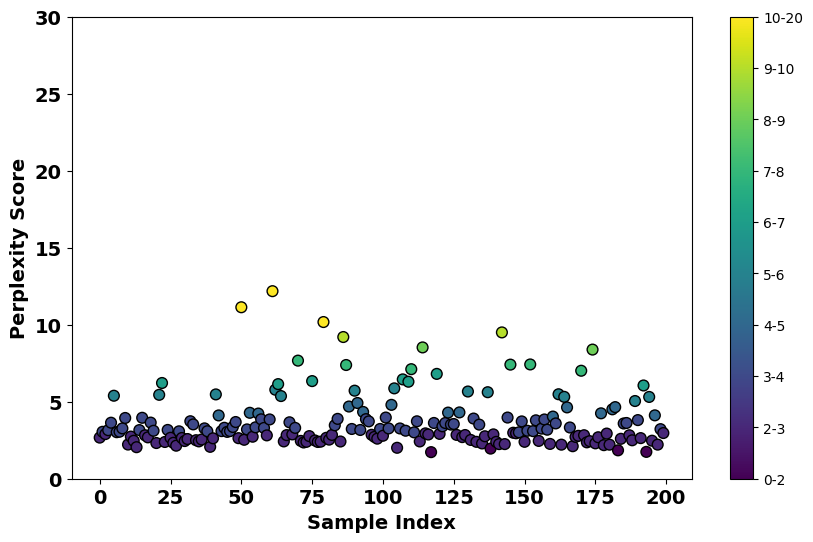

In [15]:
# Group perplexity scores into defined ranges.
# For this example, we group scores as: 0-20, 20-40, 40-60, 60-80, 80-100, and 100+
bins = [0,2,3,4,5,6,7,8,9,10,20, 40, 60, 80, 100, float('inf')]
labels = ["0-2", "2-3","3-4","4-5","5-6","6-7","7-8","8-9","9-10","10-20","20-40", "40-60", "60-80", "80-100", "100+"]
df["Perplexity Group"] = pd.cut(df["Perplexity"], bins=bins, labels=labels)

# Create a scatter plot of perplexity scores.
plt.figure(figsize=(10, 6))
# Color-code by perplexity group using categorical codes.
scatter = plt.scatter(df["Index"], df["Perplexity"], 
                      c=df["Perplexity Group"].cat.codes, cmap="viridis", s=60, edgecolor="k")
plt.xlabel("Sample Index", fontweight="bold", fontsize=14)
plt.ylabel("Perplexity Score", fontweight="bold", fontsize=14)
plt.xticks(fontsize=14, fontweight='bold')  # Increase font size and make it bold
plt.yticks(fontsize=14, fontweight='bold')  # Increase font size and make it bold

plt.title("", fontweight="bold", fontsize=16)

# Fix y-axis range from 0 to 100
plt.ylim(0, 30)

# Create a colorbar with group labels.
cbar = plt.colorbar(scatter, ticks=range(len(labels)))
cbar.ax.set_yticklabels(labels)

plt.savefig("fi_lora_dp_med_llm32_perplexity_scatter_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import re

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
generator_model = generator_model.to(device)
train_df = pd.read_csv("medical_tc_test.csv")
texts = train_df["medical_abstract"][:100].tolist()
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
prompts = [' '.join(str(text).split()[:50]) for text in texts]

def generate_long_text(model, tokenizer, prompt, max_length=100, step_size=50):
    """
    Generates a long sequence of text by repeatedly feeding the model's output as input.
    """
    # Tokenize initial prompt and move to the desired device
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)  
    
    # Store generated tokens
    generated_text_ids = input_ids.clone()    
    # Generate until max length is reached
    while generated_text_ids.shape[-1] < max_length:
        outputs = model.generate(
            input_ids=generated_text_ids.to(device),
            max_length=generated_text_ids.shape[-1] + step_size,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_k=90,
            temperature=0.8,
            top_p=0.95, num_beams=8, no_repeat_ngram_size=4,
            early_stopping=True, repetition_penalty=1.5, length_penalty=1.0,eos_token_id=tokenizer.eos_token_id
        )
        
        new_text_ids = outputs[:, generated_text_ids.shape[-1]:]
        generated_text_ids = torch.cat((generated_text_ids, new_text_ids), dim=-1)
        
        if tokenizer.eos_token_id in new_text_ids:
            break

    generated_text = tokenizer.decode(generated_text_ids[0], skip_special_tokens=True)
    generated_text = generated_text.replace("\n", "").replace("\r", "")
    #generated_text = re.sub(r'[^\w\s.,:]', '', generated_text)
    # Step 1: Remove non-ASCII characters
    generated_text = re.sub(r'[^\x00-\x7F]+', '', generated_text)
    # Step 2: Retain only letters, numbers, and basic punctuation
    #generated_text = re.sub(r'[^a-zA-Z0-9\s.,:;\'"-]', '', generated_text)
    # Step 3: Normalize spaces (remove extra spaces or newlines)
    #generated_text = re.sub(r'\s+', ' ', generated_text).strip()
    return generated_text
    
def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        #outputs = model(input_ids, labels=input_ids)
        #loss = outputs.loss  
        attention_mask = (input_ids != tokenizer.pad_token_id).long().to(device)
        labels = input_ids.clone().detach()
        #print("Input shape:", input_ids.shape)
        #print("Attention Mask shape:", attention_mask.shape)
        #print("Labels shape:", labels.shape)
        #print("Attention Mask:", attention_mask)            
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
    return torch.exp(loss).item()

def evaluate_generated_texts(reference_text, generated_text):
    reference_list = reference_text.split()
    generated_list = generated_text.split()
    bleu_score = sentence_bleu([reference_list], generated_list)
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_text, reference_text)[0]
    P = rouge_scores['rouge-l']['p']
    R = rouge_scores['rouge-l']['r']
    F1 = rouge_scores['rouge-l']['f']
    vectorizer = CountVectorizer().fit_transform([reference_text, generated_text])
    vectors = vectorizer.toarray()
    cos_sim = cosine_similarity(vectors)[0][1]
    return bleu_score, rouge_scores, P, R, F1, cos_sim

total_bleu, total_rougeL, total_perplexity, total_sim = 0, 0, 0, 0
for i, prompt in enumerate(prompts):
    reference_text = texts[i]
    generated_text_str = generate_long_text(generator_model, tokenizer, prompt, max_length=len(reference_text.split())+50,step_size=50)
    print(f"Reference Text: {reference_text}")
    print(f"Generated Text: {generated_text_str}")
    bleu_score, rouge_scores, P, R, F1, cos_sim = evaluate_generated_texts(reference_text, generated_text_str)
    perplexity = calculate_perplexity(generator_model, tokenizer, generated_text_str)
    print(f"BLEU: {bleu_score}, ROUGE-L: {rouge_scores['rouge-l']}, Perplexity: {perplexity}, Cosine Similarity: {cos_sim:.4f}")    
    total_bleu += bleu_score
    total_rougeL += rouge_scores['rouge-l']['f']
    total_perplexity += perplexity
    total_sim += cos_sim
num_samples = len(prompts)
print("Average BLEU:", total_bleu / num_samples)
print("Average ROUGE-L:", total_rougeL / num_samples)
print("Average Perplexity:", total_perplexity / num_samples)
print("Average Cosine Similarity:", total_sim / num_samples)



The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Reference Text: Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights. An acclimatization night was followed by two study nights randomly assigned to control (C) and oropharyngeal anesthesia (OPA). On the OPA night topical anesthesia was induced using 10% lidocaine spray and 0.25% bupivacaine gargle. A saline placebo was used on night C. All subjects slept well on both study nights (mean sleep duration was 6.2 h on both study nights), and sleep stage distribution was similar on both nights. Obstructive apneas and hypopn

In [8]:
torch.cuda.empty_cache()

[LightGBM] [Info] Number of positive: 79, number of negative: 81
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 215
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

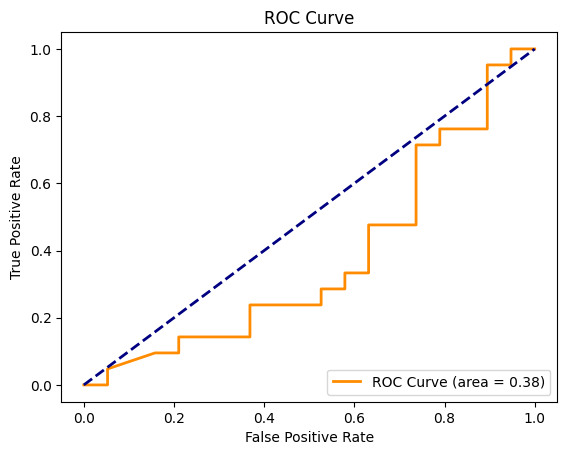

In [10]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# Load datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

train_texts = train_df["medical_abstract"][:100].tolist()
test_texts = test_df["medical_abstract"][:100].tolist()

# Function to calculate perplexity
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate prediction confidence
def calculate_prediction_confidence(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return probabilities.max().item()

# Function to calculate entropy
def calculate_entropy(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return entropy(probabilities.cpu().numpy().flatten())

# Function to calculate feature representation distance
def calculate_feature_representation_distance(model, tokenizer, text, centroid, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        #embeddings = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
        embedding_layer = model.get_input_embeddings()
        embeddings = embedding_layer(input_ids).mean(dim=1).cpu().numpy()
    return np.linalg.norm(embeddings - centroid)

# Calculate centroid for training set embeddings
def calculate_centroid(model, tokenizer, texts, device):
    embeddings = []
    for text in texts:
        input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        with torch.no_grad():
            #embedding = model.transformer.wte(input_ids).mean(dim=1).cpu().numpy()
            embedding_layer = model.get_input_embeddings()
            embedding = embedding_layer(input_ids).mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)

# Calculate centroid for training texts
train_centroid = calculate_centroid(generator_model, tokenizer, train_texts, device)

# Calculate features for training and test texts
def calculate_features(model, tokenizer, texts, centroid, device):
    perplexities, confidences, entropies, frd_distances = [], [], [], []
    for text in texts:
        perplexities.append(calculate_perplexity(model, tokenizer, text, device))
        confidences.append(calculate_prediction_confidence(model, tokenizer, text, device))
        entropies.append(calculate_entropy(model, tokenizer, text, device))
        frd_distances.append(calculate_feature_representation_distance(model, tokenizer, text, centroid, device))
    return perplexities, confidences, entropies, frd_distances

train_features = calculate_features(generator_model, tokenizer, train_texts, train_centroid, device)
test_features = calculate_features(generator_model, tokenizer, test_texts, train_centroid, device)

# Combine features and labels
train_labels = [1] * len(train_texts)  # Members
test_labels = [0] * len(test_texts)    # Non-members

combined_features = np.vstack((
    np.column_stack(train_features),
    np.column_stack(test_features)
))
combined_labels = np.array(train_labels + test_labels)

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(combined_features)

# Split data for training the attack model
X_train, X_test, y_train, y_test = train_test_split(normalized_features, combined_labels, test_size=0.2, random_state=42)

# Train LightGBM attack model
clf = LGBMClassifier(class_weight="balanced", learning_rate=0.1, n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate the attack model
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.savefig("lora_fi_dp_roc_plots_llama32.jpg", dpi=300, bbox_inches="tight")

plt.show()


In [16]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load datasets
train_df = pd.read_csv("medical_tc_train.csv")  # Adjust file name if necessary
test_df = pd.read_csv("medical_tc_test.csv")    # Adjust file name if necessary

train_texts = train_df["medical_abstract"][:200].tolist()
test_texts = test_df["medical_abstract"][:200].tolist()

def generate_long_text(model, tokenizer, prompt, max_length=300):    
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text

# Function to calculate perplexity
def calculate_perplexity(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Function to calculate prediction confidence
def calculate_prediction_confidence(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return probabilities.max().item()

# Function to calculate entropy
def calculate_entropy(model, tokenizer, text, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=-1)
        return entropy(probabilities.cpu().numpy().flatten())

# Function to calculate feature representation distance
def calculate_feature_representation_distance(model, tokenizer, text, centroid, device):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
    with torch.no_grad():
        embeddings = model.model.embed_tokens(input_ids).mean(dim=1).cpu().numpy()
    return np.linalg.norm(embeddings - centroid)

# Calculate centroid for training set embeddings
def calculate_centroid(model, tokenizer, texts, device):
    embeddings = []
    for text in texts:
        input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        with torch.no_grad():
            embedding = model.model.embed_tokens(input_ids).mean(dim=1).cpu().numpy()
        embeddings.append(embedding)
    return np.mean(embeddings, axis=0)

# Calculate centroid for training texts
train_centroid = calculate_centroid(generator_model, tokenizer, train_texts, device)
test_centroid = calculate_centroid(generator_model, tokenizer, test_texts, device)

# Calculate features for training and test texts
def calculate_features(model, tokenizer, texts, centroid, device):
    perplexities, confidences, entropies, frd_distances = [], [], [], []
    for text in texts:
        prompt = ' '.join(str(text).split()[:50])
        #print(prompt)
        text = generate_long_text(model, tokenizer, prompt, max_length=300)
        perplexities.append(calculate_perplexity(model, tokenizer, text, device))
        confidences.append(calculate_prediction_confidence(model, tokenizer, text, device))
        entropies.append(calculate_entropy(model, tokenizer, text, device))
        frd_distances.append(calculate_feature_representation_distance(model, tokenizer, text, centroid, device))
    return perplexities, confidences, entropies, frd_distances

# Open CSV file to store results
csv_filename = "fi_lora_dp_high_med_txt_llm32_attack_model_results_new.csv"
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Run", "Precision", "Recall", "F1-Score", "ROC-AUC"])

    for run in range(1, 11):  # Run 10 times
        print(f"Run {run}...")
        train_features = calculate_features(generator_model, tokenizer, train_texts, train_centroid, device)
        test_features = calculate_features(generator_model, tokenizer, test_texts, test_centroid, device)
    
        # Combine features and labels
        train_labels = [1] * len(train_texts)  # Members
        test_labels = [0] * len(test_texts)    # Non-members
    
        combined_features = np.vstack((
            np.column_stack(train_features),
            np.column_stack(test_features)
        ))
        combined_labels = np.array(train_labels + test_labels)
        # Normalize features
        scaler = MinMaxScaler()
        normalized_features = scaler.fit_transform(combined_features)      
        
        # Split data for training the attack model
        X_train, X_test, y_train, y_test = train_test_split(normalized_features, combined_labels, test_size=0.2, random_state=42 + run)

        # Train LightGBM attack model
        clf = LGBMClassifier(class_weight="balanced", learning_rate=0.1, n_estimators=100)
        clf.fit(X_train, y_train)

        # Evaluate the attack model
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        report = classification_report(y_test, y_pred, output_dict=True)
        precision = report["macro avg"]["precision"]
        recall = report["macro avg"]["recall"]
        f1_score = report["macro avg"]["f1-score"]
        roc_auc = roc_auc_score(y_test, y_pred_prob)

        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, ROC-AUC: {roc_auc:.4f}")

        # Save to CSV
        writer.writerow([run, precision, recall, f1_score, roc_auc])

print(f"Results saved to {csv_filename}")


Run 1...
[LightGBM] [Info] Number of positive: 165, number of negative: 155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [1]:
import math
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, auc, roc_auc_score, roc_curve, classification_report
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_csv = "medical_tc_train.csv"
test_csv  = "medical_tc_test.csv"
text_column = "medical_abstract"
max_samples = 200   # Limit for speed; set None for all
batch_size = 4
max_length = 300
k_percent = 20.0    # k% from algorithm
threshold_epsilon = None  # Will be tuned on training set

model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)
def load_model(model,filename='fi_lora_dp_high_medical_llama328.pth'):
    checkpoint = torch.load(filename, map_location="cuda")

    # Resize model embeddings before loading state dict
    tokenizer_vocab_size = len(tokenizer)
    model_vocab_size = checkpoint["model_state_dict"]["base_model.model.model.embed_tokens.weight"].shape[0]
    
    if tokenizer_vocab_size != model_vocab_size:
        print(f"Resizing model embeddings: {model_vocab_size} → {tokenizer_vocab_size}")
        model.resize_token_embeddings(model_vocab_size)

    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    
    epoch = checkpoint["epoch"]
    print(f"Model loaded from {filename}")
    return model, epoch
model, start_epoch = load_model(model)
model.to(device)
print("Generator model loaded successfully!")
model.eval()

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_texts = train_df["medical_abstract"].tolist()
test_texts = test_df["medical_abstract"].tolist()

# Use first 200 training samples for evaluation
train_eval_texts = train_texts[:500]
test_eval_texts = test_texts[:500]

def generate_long_text(eval_texts):
    # Build non-member texts by prompting with first 50 tokens
    prompted_texts = []
    gen_texts = []
    for text in eval_texts:
        enc = tokenizer(text, truncation=True, max_length=50, return_tensors="pt").to(device)
        prompt = tokenizer.decode(enc.input_ids[0], skip_special_tokens=True)
        prompted_texts.append(prompt)
    
        # Generate continuation
        out = model.generate(
            enc.input_ids,
            max_length=300,          # continuation length
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8,
            pad_token_id=tokenizer.eos_token_id
        )
        gen_text = tokenizer.decode(out[0], skip_special_tokens=True)
        gen_texts.append(gen_text)
        
    #print("Sample prompt:\n", prompted_texts[0])
    #print("Generated continuation:\n", gen_texts[0])
    return gen_texts


@torch.no_grad()
def seq_nll_list(model, tokenizer, txt, device, max_length=300, batch_size=4):
    """
    Returns: list of 1D numpy arrays (per-token NLL) for each sequence
    """
    enc = tokenizer(txt, return_tensors="pt", padding=True,
                        truncation=True, max_length=max_length).to(device)
    input_ids = enc.input_ids
        
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    # Apply softmax to the logits to get probabilities
    probabilities = torch.nn.functional.log_softmax(logits, dim=-1)
    # probabilities = torch.nn.functional.softmax(logits, dim=-1)
    all_prob = []
    input_ids_processed = input_ids[0][1:]
    for i, token_id in enumerate(input_ids_processed):
        probability = probabilities[0, i, token_id].item()
        all_prob.append(probability)
    return torch.exp(loss).item(), all_prob, loss.item()

def min_k_percent_nll_score(all_prob, k_percent): 
    k_length = int(len(all_prob)*0.2)    
    topk_prob = np.sort(all_prob)[:k_length]
    #print(len(topk_prob))
    return -np.mean(topk_prob).item()
member_scores = []
nonmember_scores = []
train_gen_texts = generate_long_text(train_eval_texts)
test_gen_texts = generate_long_text(test_eval_texts)

for text in train_gen_texts:
    _, all_prob_members, _ = seq_nll_list(model, tokenizer, text, device, max_length, batch_size)
    member_scores.append(min_k_percent_nll_score(all_prob_members, k_percent))
    
for text in test_gen_texts:
    _, all_prob_nonmembers, _ = seq_nll_list(model, tokenizer, text, device, max_length, batch_size)
    nonmember_scores.append(min_k_percent_nll_score(all_prob_nonmembers, k_percent))
    
scores = np.concatenate([member_scores, nonmember_scores])
labels = np.concatenate([np.ones(len(member_scores)), np.zeros(len(nonmember_scores))])
print(scores)
fpr, tpr, thresholds = roc_curve(labels, -scores)
roc_auc = auc(fpr, tpr)
f1 = np.max(1-(fpr+(1-tpr))/2)

print("\n=== Min-k% Probability MIA Results ===")
print(f"k%: {k_percent}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1: {f1:.4f}")

C:\Users\my pc\AppData\Local\Temp\ipykernel_5212\2232539925.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location="cuda")


Model loaded from fi_lora_dp_high_medical_llama328.pth


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generator model loaded successfully!
[3.80287511 3.07305451 3.6048054  4.3382377  3.19187697 2.86480504
 3.4669604  2.26746883 3.58129406 3.33332141 4.00430986 5.83880589
 4.12460496 2.93732376 5.4006293  2.62628399 4.35159058 3.456371
 3.9196229  4.51130688 3.89856945 4.00236297 3.62015629 3.28068748
 4.90572604 3.57884659 3.69884808 2.8760102  4.58037643 3.12118335
 5.72155481 3.27379864 6.62361876 4.46686235 3.77056412 3.8343525
 5.60075166 3.27204561 3.41859539 3.20299443 3.70478139 3.10997705
 3.48341879 3.30622717 3.80678683 3.10248802 3.30779759 3.83864342
 3.1875769  5.30130494 3.57691401 6.22630944 6.32254202 3.64466543
 3.77371711 3.41682817 3.02715304 4.53355157 4.01554645 3.18116436
 3.31419431 3.50567456 3.20800533 3.63194655 3.56636774 3.90131329
 4.18036089 3.28856384 2.86672966 3.73737649 3.6527549  3.09156491
 3.18668614 3.47201259 3.28466297 3.05899915 6.76900478 4.6994687
 4.17926616 3.90257798 3.17562249 3.3656795  2.65344045 2.36818538
 3.34531081 3.57299183 5.3599

In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

from sklearn.metrics import roc_curve, auc, accuracy_score

# ----------------------------
# Settings
# ----------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_csv = "medical_tc_train.csv"
test_csv  = "medical_tc_test.csv"
NUM_NEIGHBORS = 1                            # number of neighbors to generate per text
MAX_GEN_LEN = 64                             # max length for neighbor generation

# ----------------------------
# Load model and tokenizer
# ----------------------------
model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)
def load_model(model,filename='fi_lora_dp_high_medical_llama328.pth'):
    checkpoint = torch.load(filename, map_location="cuda")

    # Resize model embeddings before loading state dict
    tokenizer_vocab_size = len(tokenizer)
    model_vocab_size = checkpoint["model_state_dict"]["base_model.model.model.embed_tokens.weight"].shape[0]
    
    if tokenizer_vocab_size != model_vocab_size:
        print(f"Resizing model embeddings: {model_vocab_size} → {tokenizer_vocab_size}")
        model.resize_token_embeddings(model_vocab_size)

    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    
    epoch = checkpoint["epoch"]
    print(f"Model loaded from {filename}")
    return model, epoch
model, start_epoch = load_model(model)
model.to(device)
print("Generator model loaded successfully!")
model.eval()

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_texts = train_df["medical_abstract"][:500].tolist()
test_texts = test_df["medical_abstract"][:500].tolist()

# ----------------------------
# Inference: log-likelihood
# ----------------------------
def compute_log_likelihood(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
    return -loss.item()   # higher = more likely under model

# ----------------------------
# Generate neighbor texts
# ----------------------------
def generate_neighbors(text, model, tokenizer, num_neighbors=NUM_NEIGHBORS, max_length=MAX_GEN_LEN):
    enc = tokenizer(text, truncation=True, max_length=50, return_tensors="pt").to(device)
    neighbors = []
    with torch.no_grad():
        for _ in range(num_neighbors):
            output = model.generate(
                enc.input_ids,
                max_length=128,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.8,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_text = tokenizer.decode(output[0], skip_special_tokens=True)
            neighbors.append(gen_text)
    return neighbors

# ----------------------------
# Compute neighbor scores
# ----------------------------
member_scores = []
for i, text in enumerate(tqdm(train_texts, desc="Samples")):
    ll = compute_log_likelihood(text, model, tokenizer)
    neighbors = generate_neighbors(text, model, tokenizer, NUM_NEIGHBORS, MAX_GEN_LEN)
    ll_neighbors = [compute_log_likelihood(nb, model, tokenizer) for nb in neighbors]
    score = ll - np.mean(ll_neighbors)
    member_scores.append(score)
nonmember_scores = []
for i, text in enumerate(tqdm(test_texts, desc="Samples")):
    ll = compute_log_likelihood(text, model, tokenizer)
    neighbors = generate_neighbors(text, model, tokenizer, NUM_NEIGHBORS, MAX_GEN_LEN)
    ll_neighbors = [compute_log_likelihood(nb, model, tokenizer) for nb in neighbors]
    score = ll - np.mean(ll_neighbors)
    nonmember_scores.append(score)
scores = np.concatenate([member_scores, nonmember_scores])
labels = np.concatenate([np.ones(len(member_scores)), np.zeros(len(nonmember_scores))])
# ----------------------------
# Compute Metrics
# ----------------------------
fpr, tpr, thresholds = roc_curve(labels, scores)
auroc = auc(fpr, tpr)
f1 = np.max(1-(fpr+(1-tpr))/2)
print("=== Results ===")
print(f"AUROC: {auroc:.3f}")
print(f"F1: {f1:.3f}")


C:\Users\my pc\AppData\Local\Temp\ipykernel_27348\1103411455.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location="cuda")


Model loaded from fi_lora_dp_high_medical_llama328.pth
Generator model loaded successfully!


Samples: 100%|██████████| 500/500 [07:31<00:00,  1.11it/s]

=== Results ===
AUROC: 0.501
F1: 0.523


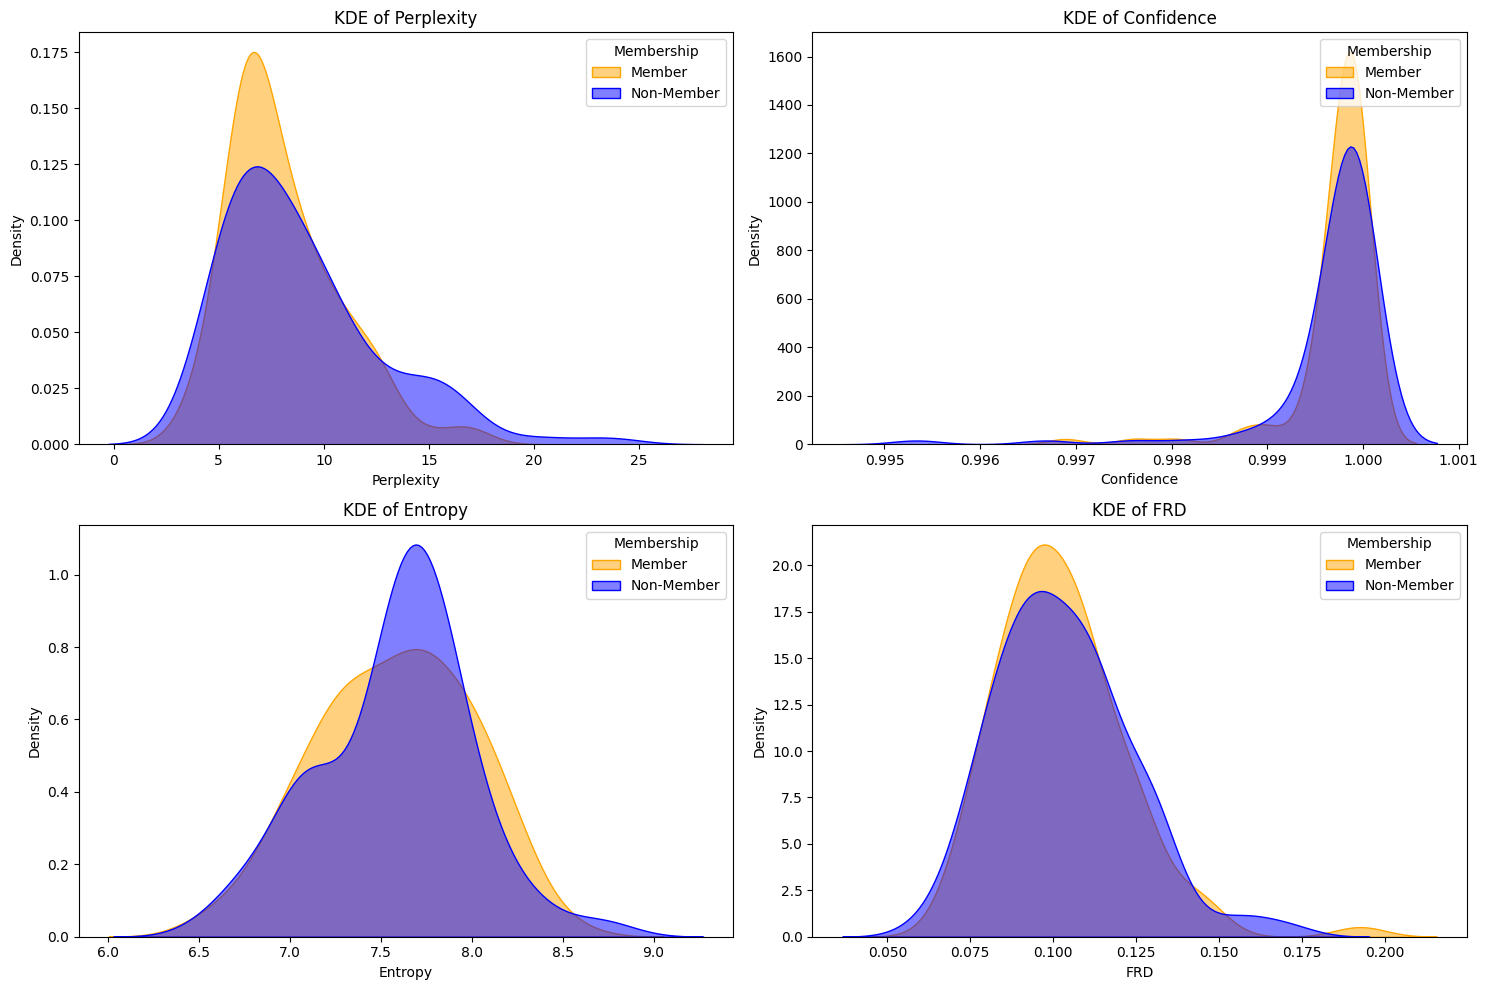

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract individual feature arrays
train_perplexities, train_confidences, train_entropies, train_frd = train_features
test_perplexities, test_confidences, test_entropies, test_frd = test_features

# Combine train and test features for each category
perplexities = np.concatenate([train_perplexities, test_perplexities])
confidences = np.concatenate([train_confidences, test_confidences])
entropies = np.concatenate([train_entropies, test_entropies])
frd_distances = np.concatenate([train_frd, test_frd])

# Combine member (1) and non-member (0) labels
labels = np.concatenate([[1] * len(train_perplexities), [0] * len(test_perplexities)])

df = pd.DataFrame({
    "Perplexity": perplexities,
    "Confidence": confidences,
    "Entropy": entropies,
    "FRD": frd_distances,
    "Membership": labels
})

# Convert Membership to categorical for seaborn
df["Membership"] = df["Membership"].map({1: "Member", 0: "Non-Member"})

# Plot KDE for each feature
features = ["Perplexity", "Confidence", "Entropy", "FRD"]
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=df, x=feature, hue="Membership", fill=True, common_norm=False, alpha=0.5, palette={"Member": "blue", "Non-Member": "orange"} )
    plt.title(f"KDE of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend(
        title="Membership", 
        loc="upper right", 
        labels=["Member", "Non-Member"], 
        frameon=True
    )

plt.tight_layout()
plt.savefig("lora_fi_dp_kde_plots_llama32.jpg", dpi=300, bbox_inches="tight")

plt.show()


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()
PROMPT_LENGTH=50
def tokenize_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    return inputs

def decode_tokens(tokens):
    return [tokenizer.decode([token]) for token in tokens]

def compute_shap_values(model, tokenizer, text, max_length=300):
    inputs = tokenize_text(text)
    input_ids = inputs["input_ids"].to(device)  # Extract the 'input_ids' tensor
    #print(f"INPUT IDS: {input_ids} and SHAPE: {input_ids.shape}")
    # Generate synthetic texts with prompts (subset of input_ids)
    prompts = input_ids[:, :PROMPT_LENGTH]  # Slice to use only the first 50 tokens as the prompt
    generated_ids = model.generate(input_ids=prompts,max_length=300+10,do_sample=True,top_k=90,temperature=0.8,top_p=0.95, num_beams=8, 
                                       no_repeat_ngram_size=4,early_stopping=True, repetition_penalty=1.5, length_penalty=1.0,
                                       pad_token_id=tokenizer.pad_token_id,eos_token_id=tokenizer.eos_token_id)
    #input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)      
    tokens = tokenizer.tokenize(text)
    input_texts_np = np.array(tokens).reshape(-1, 1)
    #print(f"INPUT IDS: {input_texts_np} and SHAPE: {input_texts_np.shape}")
    explainer = shap.KernelExplainer(
           lambda texts: model(**tokenizer(list(texts.flatten()), return_tensors="pt", 
                                                      padding=True, truncation=True).to(device)).logits[:, -1, :].cpu().detach().numpy(), input_texts_np  # Baseline as 2D NumPy array
    )
    #shap_values = explainer.shap_values(input_texts_np, nsamples=100)
    #token_importances = np.mean(np.abs(shap_values), axis=-1).flatten()
    #print(f"TOKEN IMP: {token_importances}")
    shap_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)   
    print(shap_texts[0])
    gen_inputs = tokenize_text(shap_texts[0])
    gen_input_ids = gen_inputs["input_ids"].to(device)  # Extract the 'input_ids' tensor    
    gen_tokens = tokenizer.tokenize(shap_texts[0])
    shap_texts_np = np.array(gen_tokens).reshape(-1, 1) 
    shap_values = explainer.shap_values(shap_texts_np, nsamples=100)    
    return shap_texts[0], shap_values
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights. An acclimatization night was followed by two study nights randomly assigned to control (C) and oropharyngeal anesthesia (OPA). On the OPA night topical anesthesia was induced using 10% lidocaine spray and 0.25% bupivacaine gargle. A saline placebo was used on night C. All subjects slept well on both study nights (mean sleep duration was 6.2 h on both study nights), and sleep stage distribution was similar on both nights. Obstructive apneas and hypopneas (OAH) rose from 114 +/- 43 during C to 170 +/- 49 during OPA (p less than 0.02). Central apneas and hypopneas (CAH) were unchanged between the two nights (8 +/- 4.9 versus 7 +/- 3). The duration of OAH was similar on both study nights (20 +/- 1.9 s during C versus 20 +/- 1.5 s during OPA). The frequency of movement arousals terminating OAH tended to be higher during OPA (7 +/- 2.9/h) than during C (3 +/- 0.7); P = NS. The frequency of oxyhemoglobin desaturations was also higher during OPA (5 +/- 2.1/h) than during C (3 +/- 1.4), p less than 0.07."
# Compute SHAP values for tokens
text, shap_values = compute_shap_values(model, tokenizer, text)
#print(f"Raw SHAP values:{shap_values} SHAPE:{shap_values.shape}")
# Extract token importance
#token_importances = np.mean(np.abs(shap_values), axis=-1).flatten()
token_importances = np.mean(shap_values, axis=-1).flatten()
# Decode tokens
tokens = decode_tokens(tokenizer(text, return_tensors="pt")["input_ids"][0].tolist())
print(len(tokens))
print(len(token_importances))
#for i, (token, importance) in enumerate(zip(tokens, token_importances)):
#    #if i < 10:  # Limit to the first 10 for debug purposes
#    print(f"I:  {i} Token: {token} | SHAP Value: {importance}")




Using 395 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the role of this mechanism in obstructive sleep apnoea (OSA) in a group of patients with loud snoring and OSA. Patients with OSA were compared with a control group of patients without OSA who did not have loud snoring. The control group was matched for age, sex and body mass index (BMI) with the OSA group. All patients underwent polysomnography (PSG) and nasal endoscopy (NE). Nasal endoscopy was used to assess the presence of a uvulopalatopharyngoplasty (UPPP) flap at the level of the soft palate. OSA was defined as an apnoea-hypopnoea index (AHI) of 15 or more events per hour of sleep. There were no significant differences between the OSA and control groups in terms of age, sex or BMI. The OSA group had a significantly higher AHI than the co

  0%|          | 0/309 [00:00<?, ?it/s]

310
39631104


In [17]:
# Initialize empty lists for tokens and SHAP values
tokens_list = []
shap_values_list = []

# Iterate through the tokens and their corresponding SHAP values
for i, (token, importance) in enumerate(zip(tokens, token_importances)):
    # Add token and importance to the lists
    tokens_list.append(token)
    shap_values_list.append(importance)

# Create a list of tuples (token, shap_value) and sort by shap_value in descending order
sorted_tokens_shap = sorted(zip(tokens_list, shap_values_list), key=lambda x: abs(x[1]), reverse=True)

# Get the top 50 tokens and SHAP values
top_50_tokens, top_50_shap_values = zip(*sorted_tokens_shap[:150])

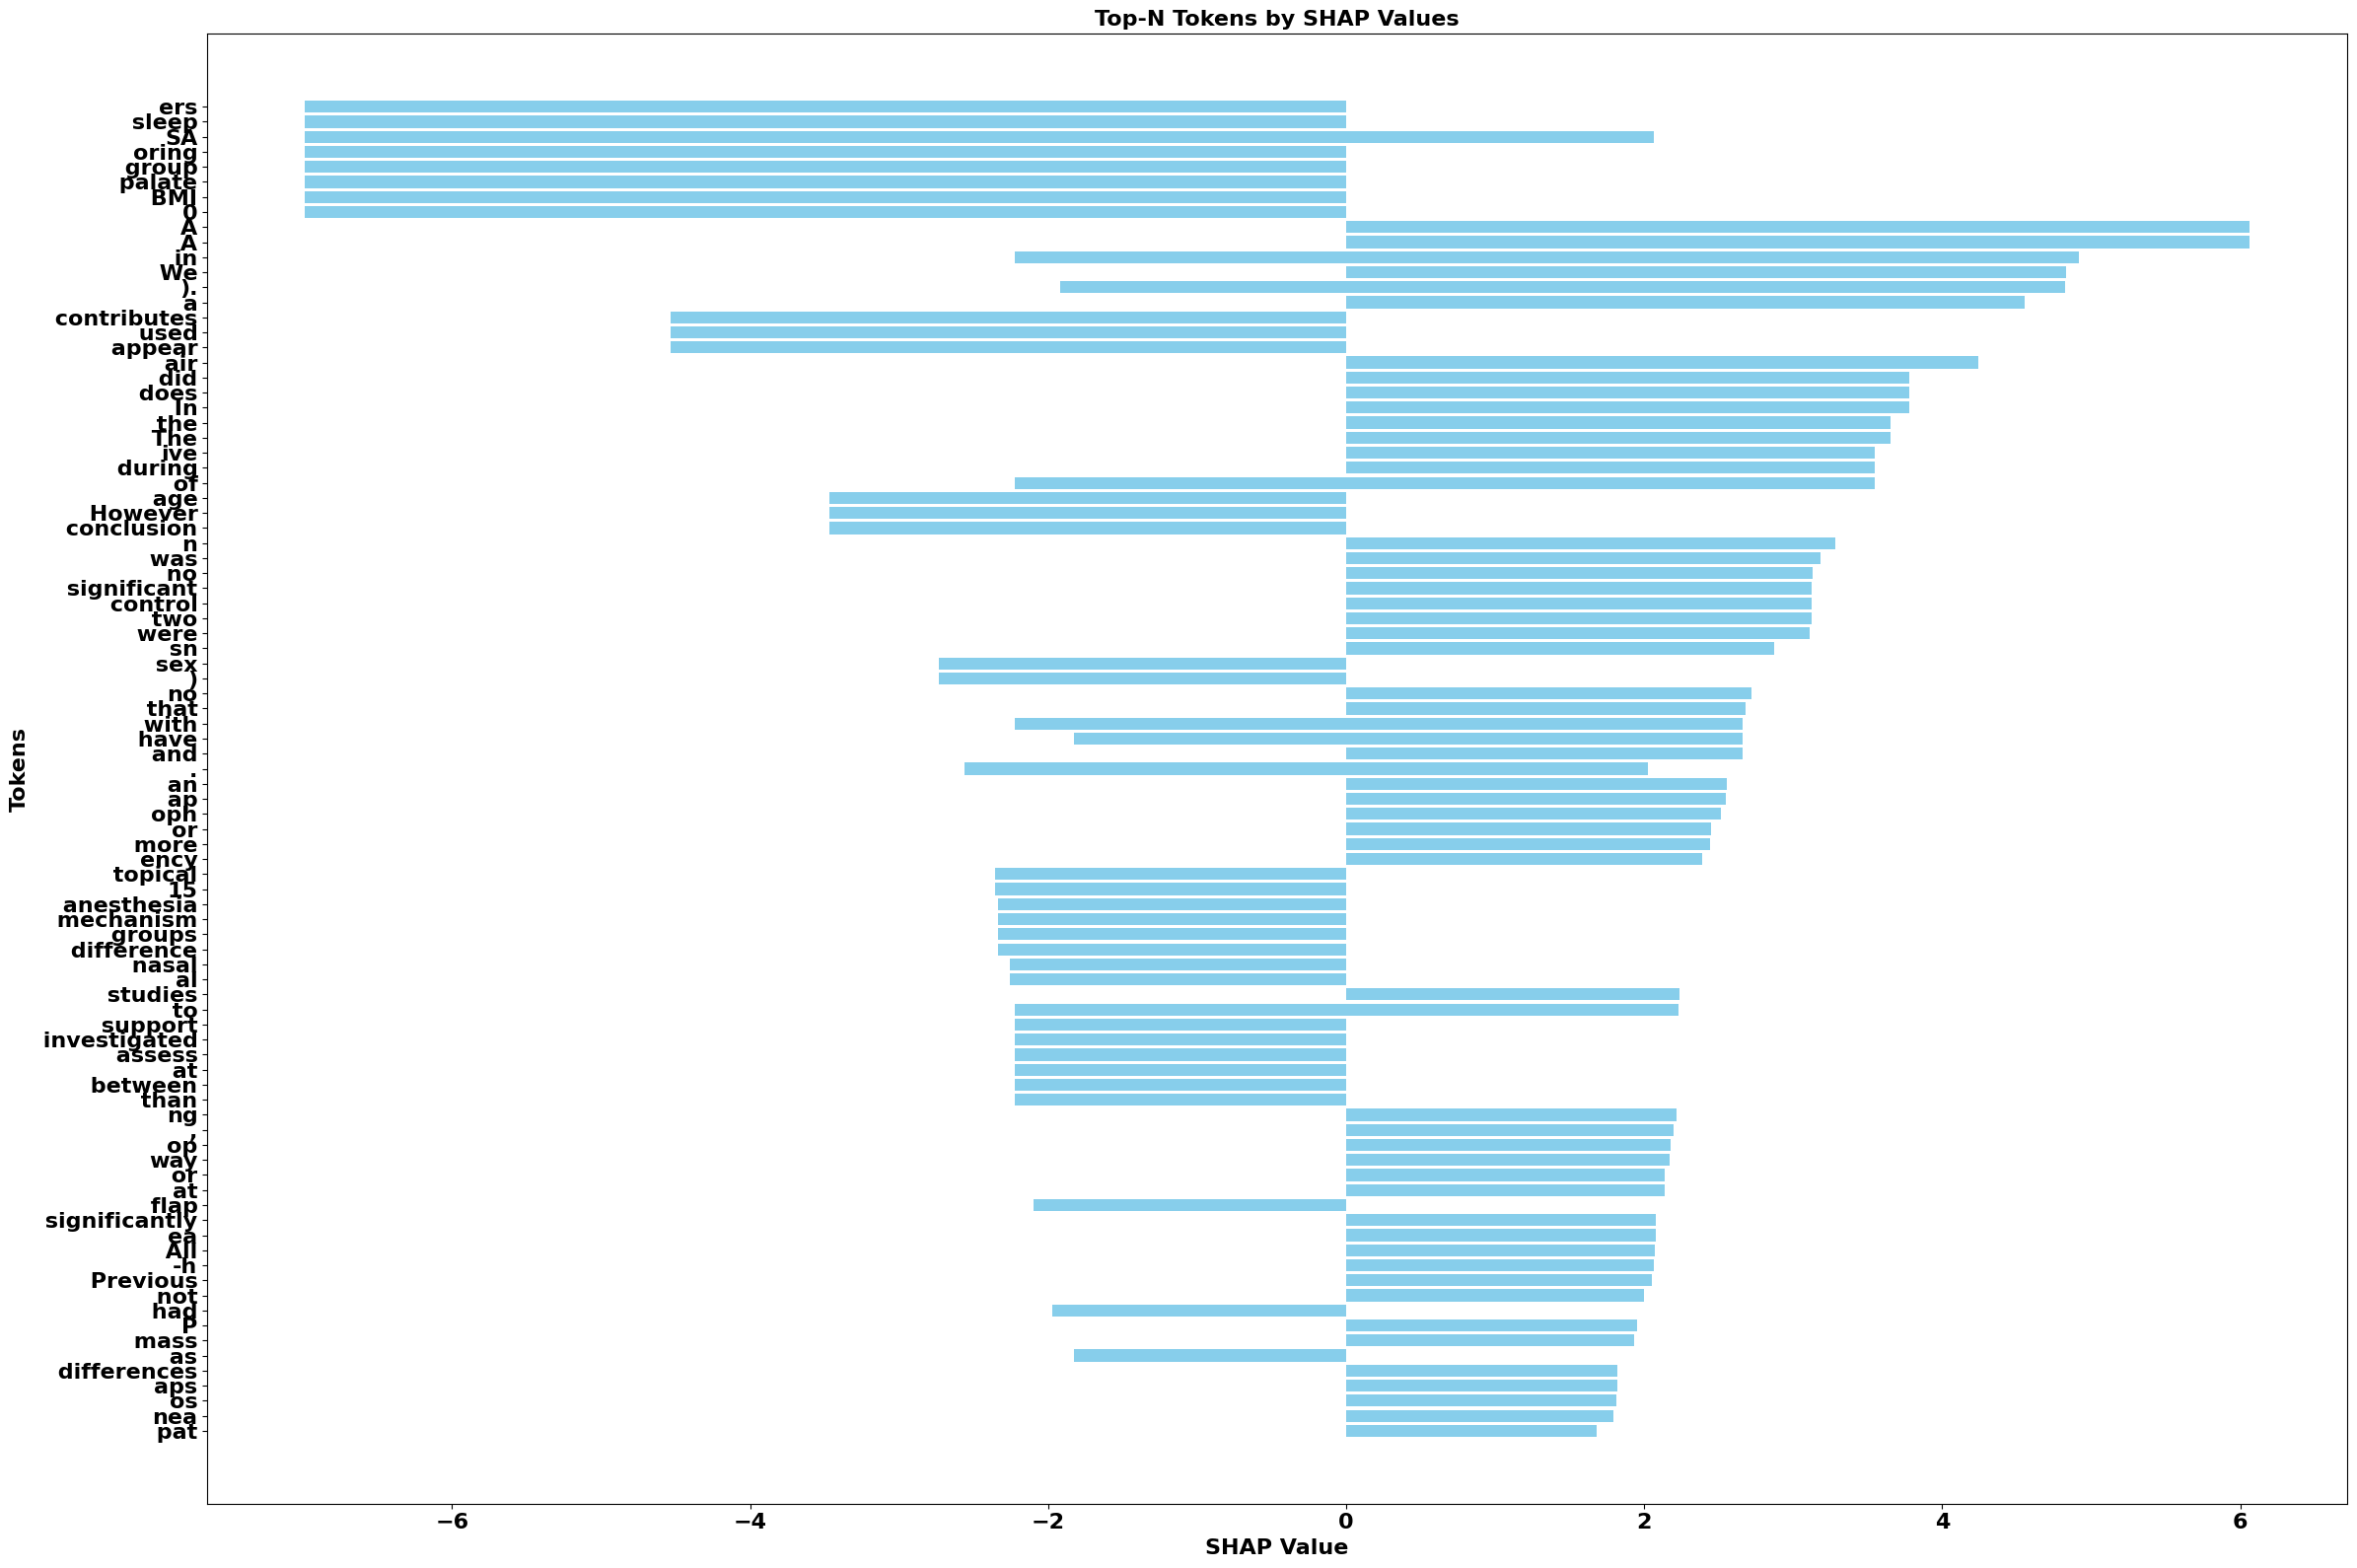

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the bar chart
plt.figure(figsize=(24, 16))
plt.barh(top_50_tokens, top_50_shap_values, color="skyblue")
plt.xlabel("SHAP Value", fontsize=16, fontweight='bold')
plt.ylabel("Tokens", fontsize=16, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')  # Set font size and make them bold
plt.yticks(fontsize=16, fontweight='bold')  # Set font size and make them bold
plt.title("Top-N Tokens by SHAP Values", fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Invert y-axis to display highest SHAP value at the top
plt.tight_layout()
plt.savefig('fi_shap_plot_llama32.jpg')
plt.show()


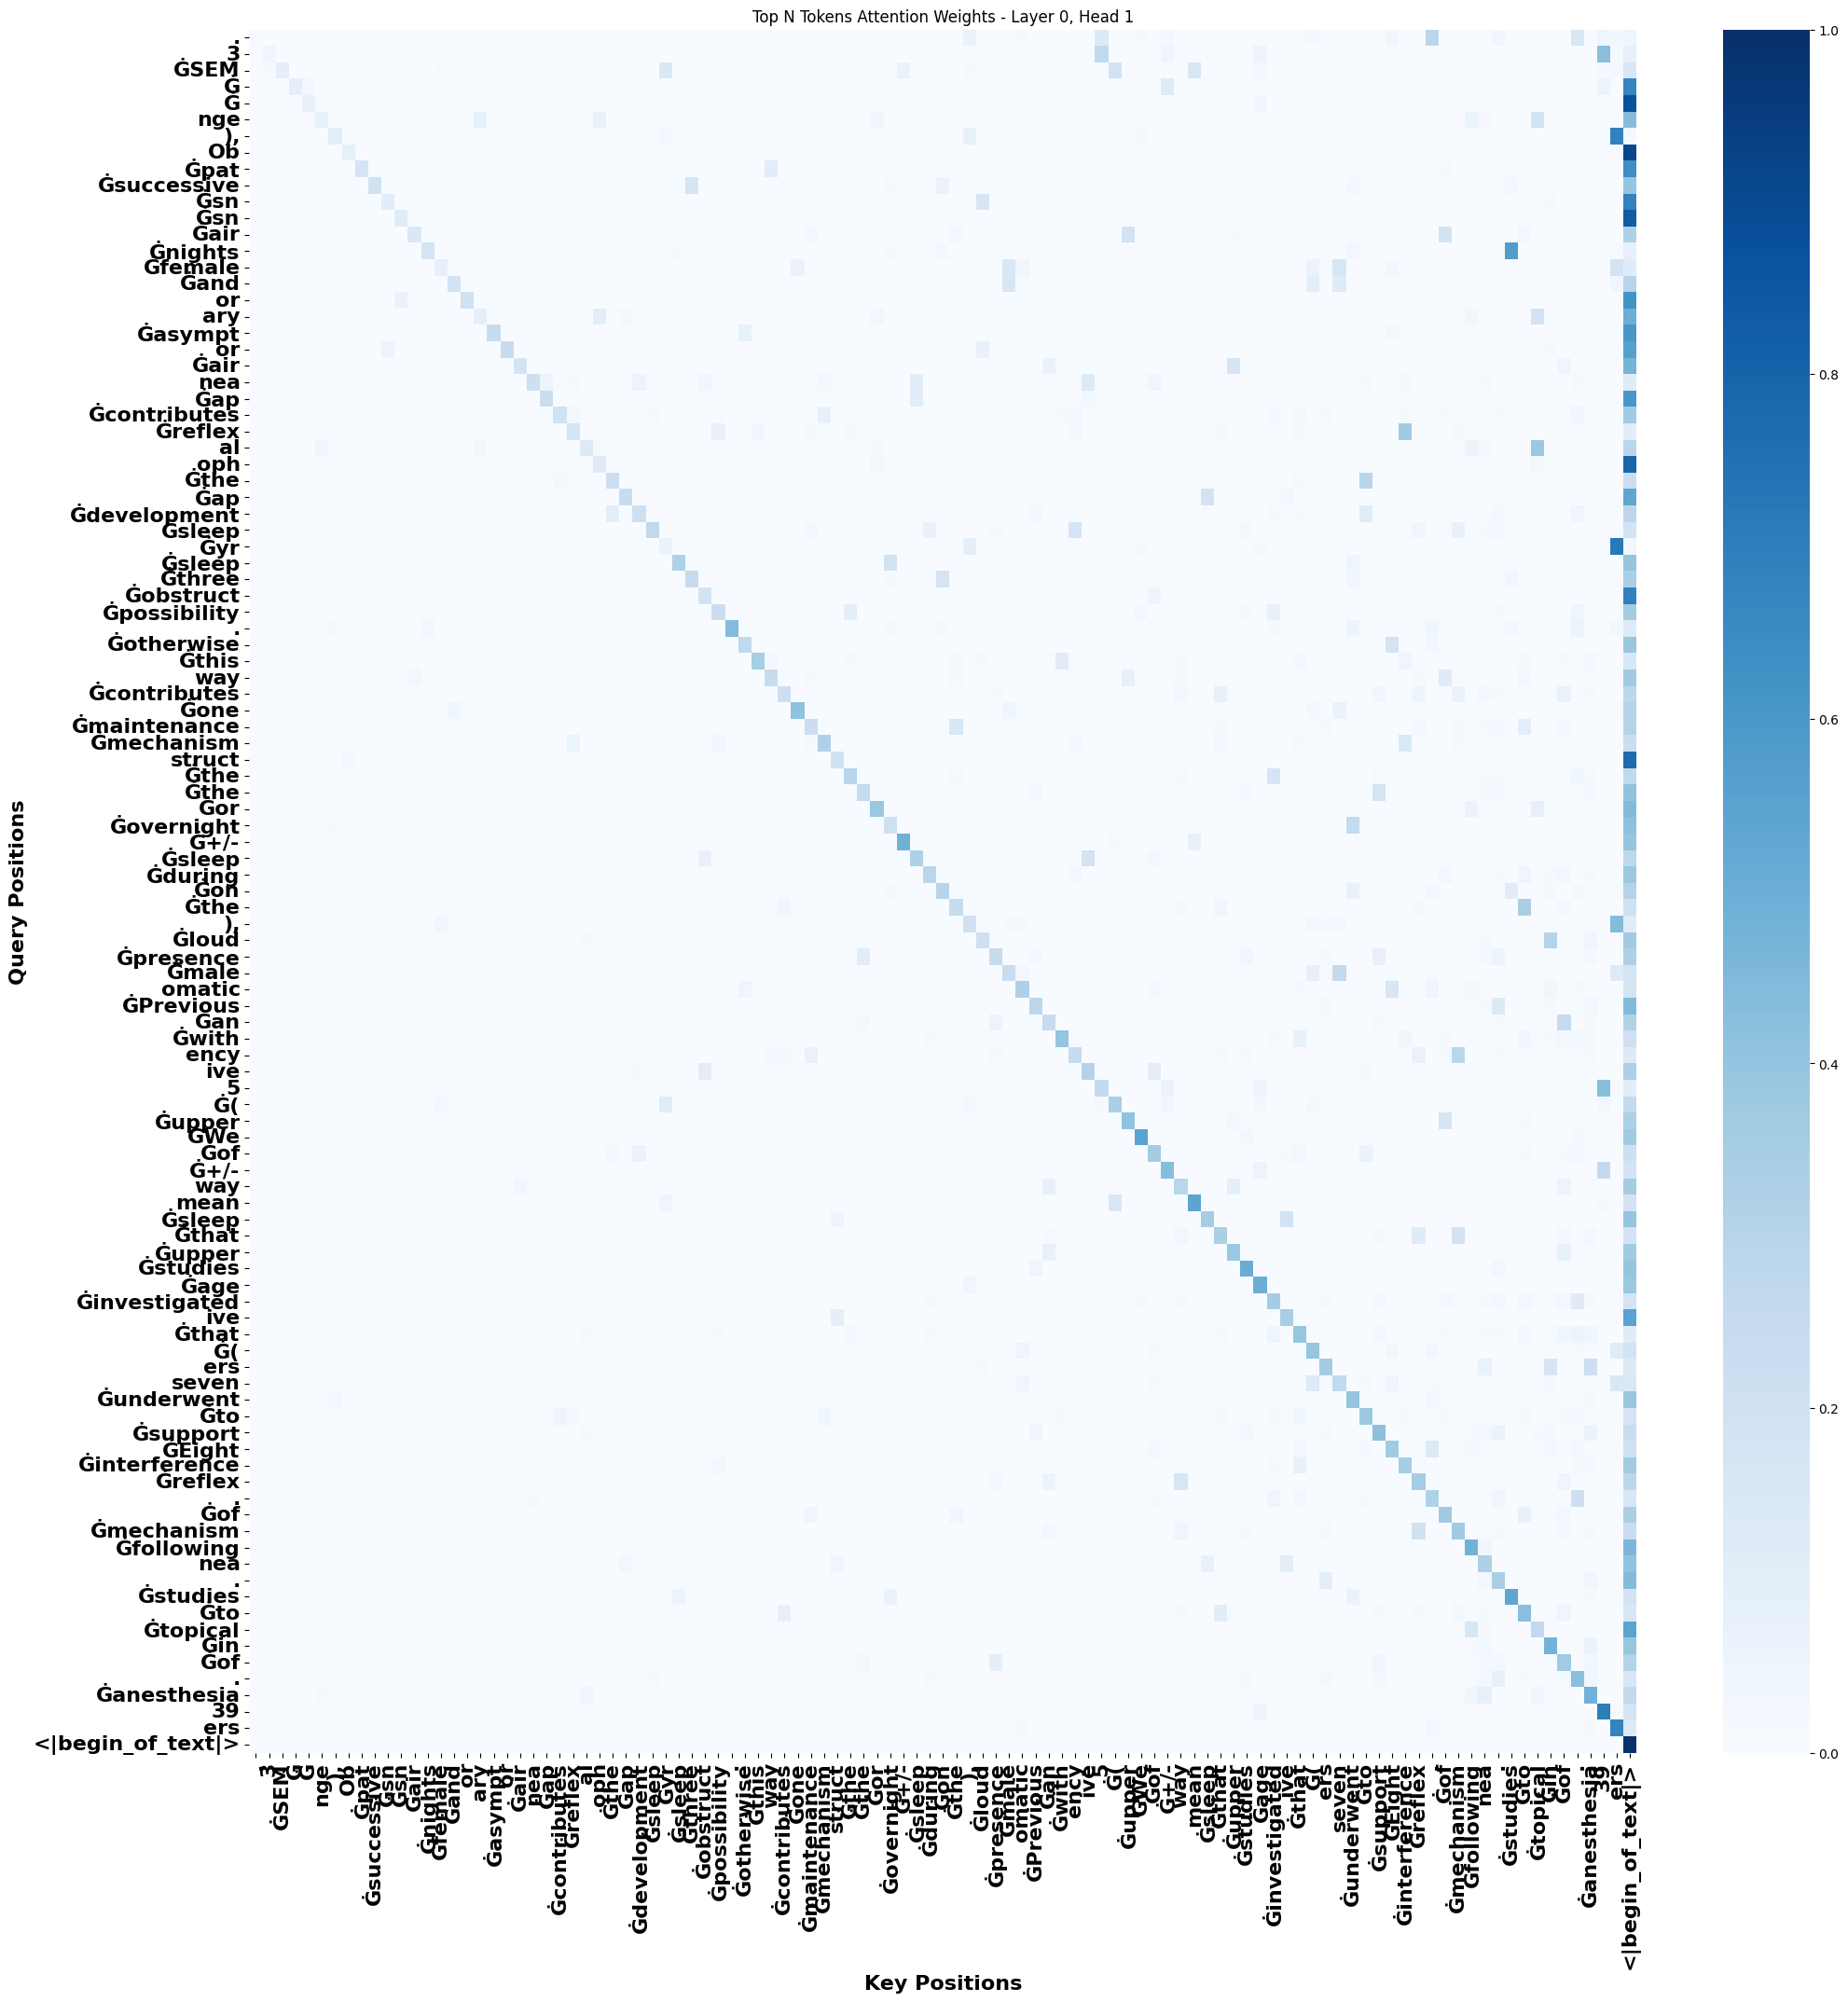

In [24]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Input text
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights."

# Device setup
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Tokenize input
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=309).to(device)

# Forward pass with attention outputs
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Extract attention matrices (layers, batch, heads, seq_len, seq_len)
attentions = outputs.attentions  
layer_idx = -1  # Last layer
head_idx = 0    # First attention head

# Extract attention matrix for the chosen layer and head
attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

# Retrieve token names
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Compute average attention per token
avg_attention = attention_matrix.mean(axis=0)  # Mean across queries

# Select top 150 tokens based on average attention
top_indices = np.argsort(avg_attention)[-150:]  # Get indices of highest attention tokens
top_tokens = [tokens[i] for i in top_indices]   # Get corresponding tokens
top_attention_matrix = attention_matrix[np.ix_(top_indices, top_indices)]  # Filter matrix

# Plot heatmap with token names
plt.figure(figsize=(24, 24))
sns.heatmap(top_attention_matrix, cmap="Blues", xticklabels=top_tokens, yticklabels=top_tokens, annot=False)
plt.xticks(rotation=90,fontsize=16, fontweight='bold')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=16, fontweight='bold')  # Rotate x-axis labels for better readability
plt.xlabel("Key Positions",fontsize=16, fontweight='bold')
plt.ylabel("Query Positions",fontsize=16, fontweight='bold')
plt.title(f"Top N Tokens Attention Weights - Layer {layer_idx+1}, Head {head_idx+1}")
plt.savefig('fi_attn_map_llama32.jpg')
plt.show()


LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


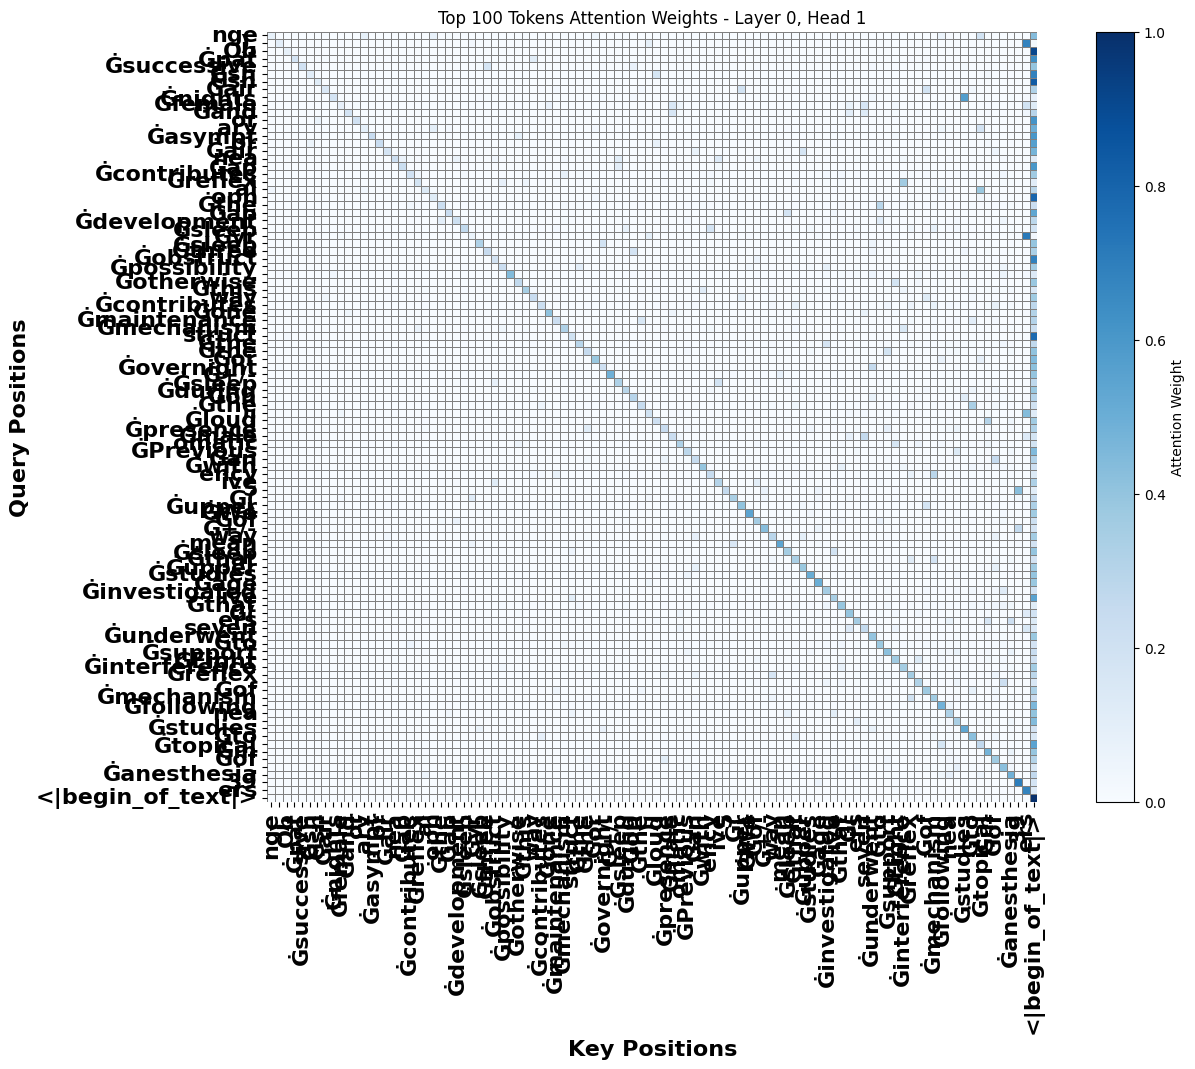

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
def visualize_attention(model, tokenizer, text, layer_idx=-1, head_idx=0, top_n_tokens=150, filename="attention_heatmap.jpg"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions
    attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    avg_attention = attention_matrix.mean(axis=0)
    top_indices = np.argsort(avg_attention)[-top_n_tokens:]
    top_tokens = [tokens[i] for i in top_indices]
    top_attention_matrix = attention_matrix[np.ix_(top_indices, top_indices)]
    df = pd.DataFrame(top_attention_matrix, index=top_tokens, columns=top_tokens)
    df.to_csv("fi_lora_dp_med_txt_llm32_top_attention_matrix.csv")
    plt.figure(figsize=(15, 10))
    # Create the heatmap and store the result (QuadMesh object)
    heatmap = sns.heatmap(
        top_attention_matrix,
        cmap="Blues",
        linewidths=0.5,
        linecolor="gray",
        square=True,
        cbar=False,
        vmin=0, vmax=1,
        xticklabels=top_tokens, yticklabels=top_tokens
    )
    plt.xticks(rotation=90, fontsize=16, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    plt.xlabel("Key Positions", fontsize=16, fontweight='bold')
    plt.ylabel("Query Positions", fontsize=16, fontweight='bold')
    plt.title(f"Top {top_n_tokens} Tokens Attention Weights - Layer {layer_idx+1}, Head {head_idx+1}")
    plt.colorbar(heatmap.collections[0], label="Attention Weight") # Pass the QuadMesh object to colorbar

    plt.savefig(filename)
    plt.show()
text = "Obstructive sleep apnea following topical oropharyngeal anesthesia in loud snorers. Previous studies support the presence of an upper airway reflex mechanism that contributes to the maintenance of upper airway patency during sleep. We investigated the possibility that interference with this reflex mechanism contributes to the development of obstructive sleep apnea. Eight otherwise asymptomatic snorers (seven male and one female), age 39 +/- 5.3 yr (mean +/- SEM), underwent overnight sleep studies on three successive nights."
# Example usage
visualize_attention(generator_model, tokenizer, text, layer_idx=-1, head_idx=0, top_n_tokens=100, filename="fi_lora_dp_high_med_txt_gen_attn_map.jpg")


C:\Users\my pc\AppData\Local\Temp\ipykernel_19276\4179861113.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y="Cosine Similarity", data=df_sim, palette="coolwarm")


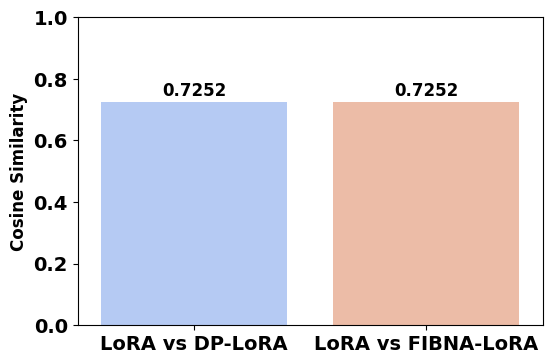

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load attention weight matrices
attn_lora = pd.read_csv("lora_med_txt_llm32_top_attention_matrix.csv", index_col=0).values  
attn_dp = pd.read_csv("lora_dp_med_txt_llm32_top_attention_matrix.csv", index_col=0).values  
attn_fi_lora_dp = pd.read_csv("fi_lora_dp_med_txt_llm32_top_attention_matrix.csv", index_col=0).values  

# Flatten matrices for cosine similarity computation
vec_lora = attn_lora.flatten().reshape(1, -1)
vec_dp = attn_dp.flatten().reshape(1, -1)
vec_fi_lora_dp = attn_fi_lora_dp.flatten().reshape(1, -1)

# Compute cosine similarities with LoRA fine-tuning as the baseline
cos_sim_dp = cosine_similarity(vec_lora, vec_dp)[0][0]
cos_sim_fi_lora_dp = cosine_similarity(vec_lora, vec_fi_lora_dp)[0][0]

# Create DataFrame for visualization
df_sim = pd.DataFrame({
    "Method": ["LoRA vs DP-LoRA", "LoRA vs FIBNA-LoRA"],
    "Cosine Similarity": [cos_sim_dp, cos_sim_fi_lora_dp]
})

# ---- Visualization ----
plt.figure(figsize=(6, 4))
sns.barplot(x="Method", y="Cosine Similarity", data=df_sim, palette="coolwarm")
plt.ylim(0, 1)  # Cosine similarity range
plt.ylabel("Cosine Similarity", fontsize=12, fontweight="bold")
plt.xlabel("",fontsize=14, fontweight="bold")
plt.title("", fontsize=14, fontweight="bold")
plt.xticks(fontsize=14, fontweight="bold")
plt.yticks(fontsize=14, fontweight="bold")

# Annotate bars with similarity values
for index, row in df_sim.iterrows():
    plt.text(index, row["Cosine Similarity"] + 0.02, f"{row['Cosine Similarity']:.4f}", ha='center', fontsize=12, fontweight="bold")

# Save & Show Plot
plt.savefig("med_txt_llm32_cosine_similarity_comparison.jpg", dpi=300, bbox_inches="tight")
plt.show()
